# Dynamic breakpoints 

## Review

We disussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We covered breakpoints as a general way to stop the graph at specific steps, which enables use-cases like `Approval`

We also showed how to edit graph state. 

## Goals

Breakpoints as discussed are set by the developer before or after a node is executed. 

But oftentimes it may be helpful to allow the graph **dynamically interrupt** itself!

This is an internal breakpoint, and [can be achieved using `NodeInterrupt`](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

This has a few specific benefits: 

(1) you can do it conditionally (from inside a node based on logic).

(2) you can communicate to the user why its interrupted (by passing whatever you want to the `NodeInterrupt`).

Let's create a graph where a  is thrown based upon lenth of the input.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

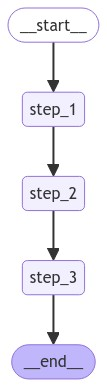

In [6]:
from IPython.display import Image, display

from typing import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's run the graph with an input that's longer than 5 characters. 

In [7]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


If we inspect the graph state at this point, we can see the information on what node is set to execute next (`step_2`).


In [8]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


We can see that this is logged to state.

In [9]:
print(state.tasks)

(PregelTask(id='ee65ac5e-8f2d-5d46-aaf6-8c29d0b951c4', name='step_2', error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', when='during'),)),)


We can try to resume the graph from the breakpoint. 

But, this just re-runs the same node! 

Unless state is changed we will be stuck here.

Let's try to resume.

In [10]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

In [13]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


Now, we can update state.

In [11]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64c25-a660-63a6-8002-341496163bcf'}}

In [12]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


### Usage with LangGraph API

Now, let's run this with the LangGraph API.

We have the above graph running in Studio.

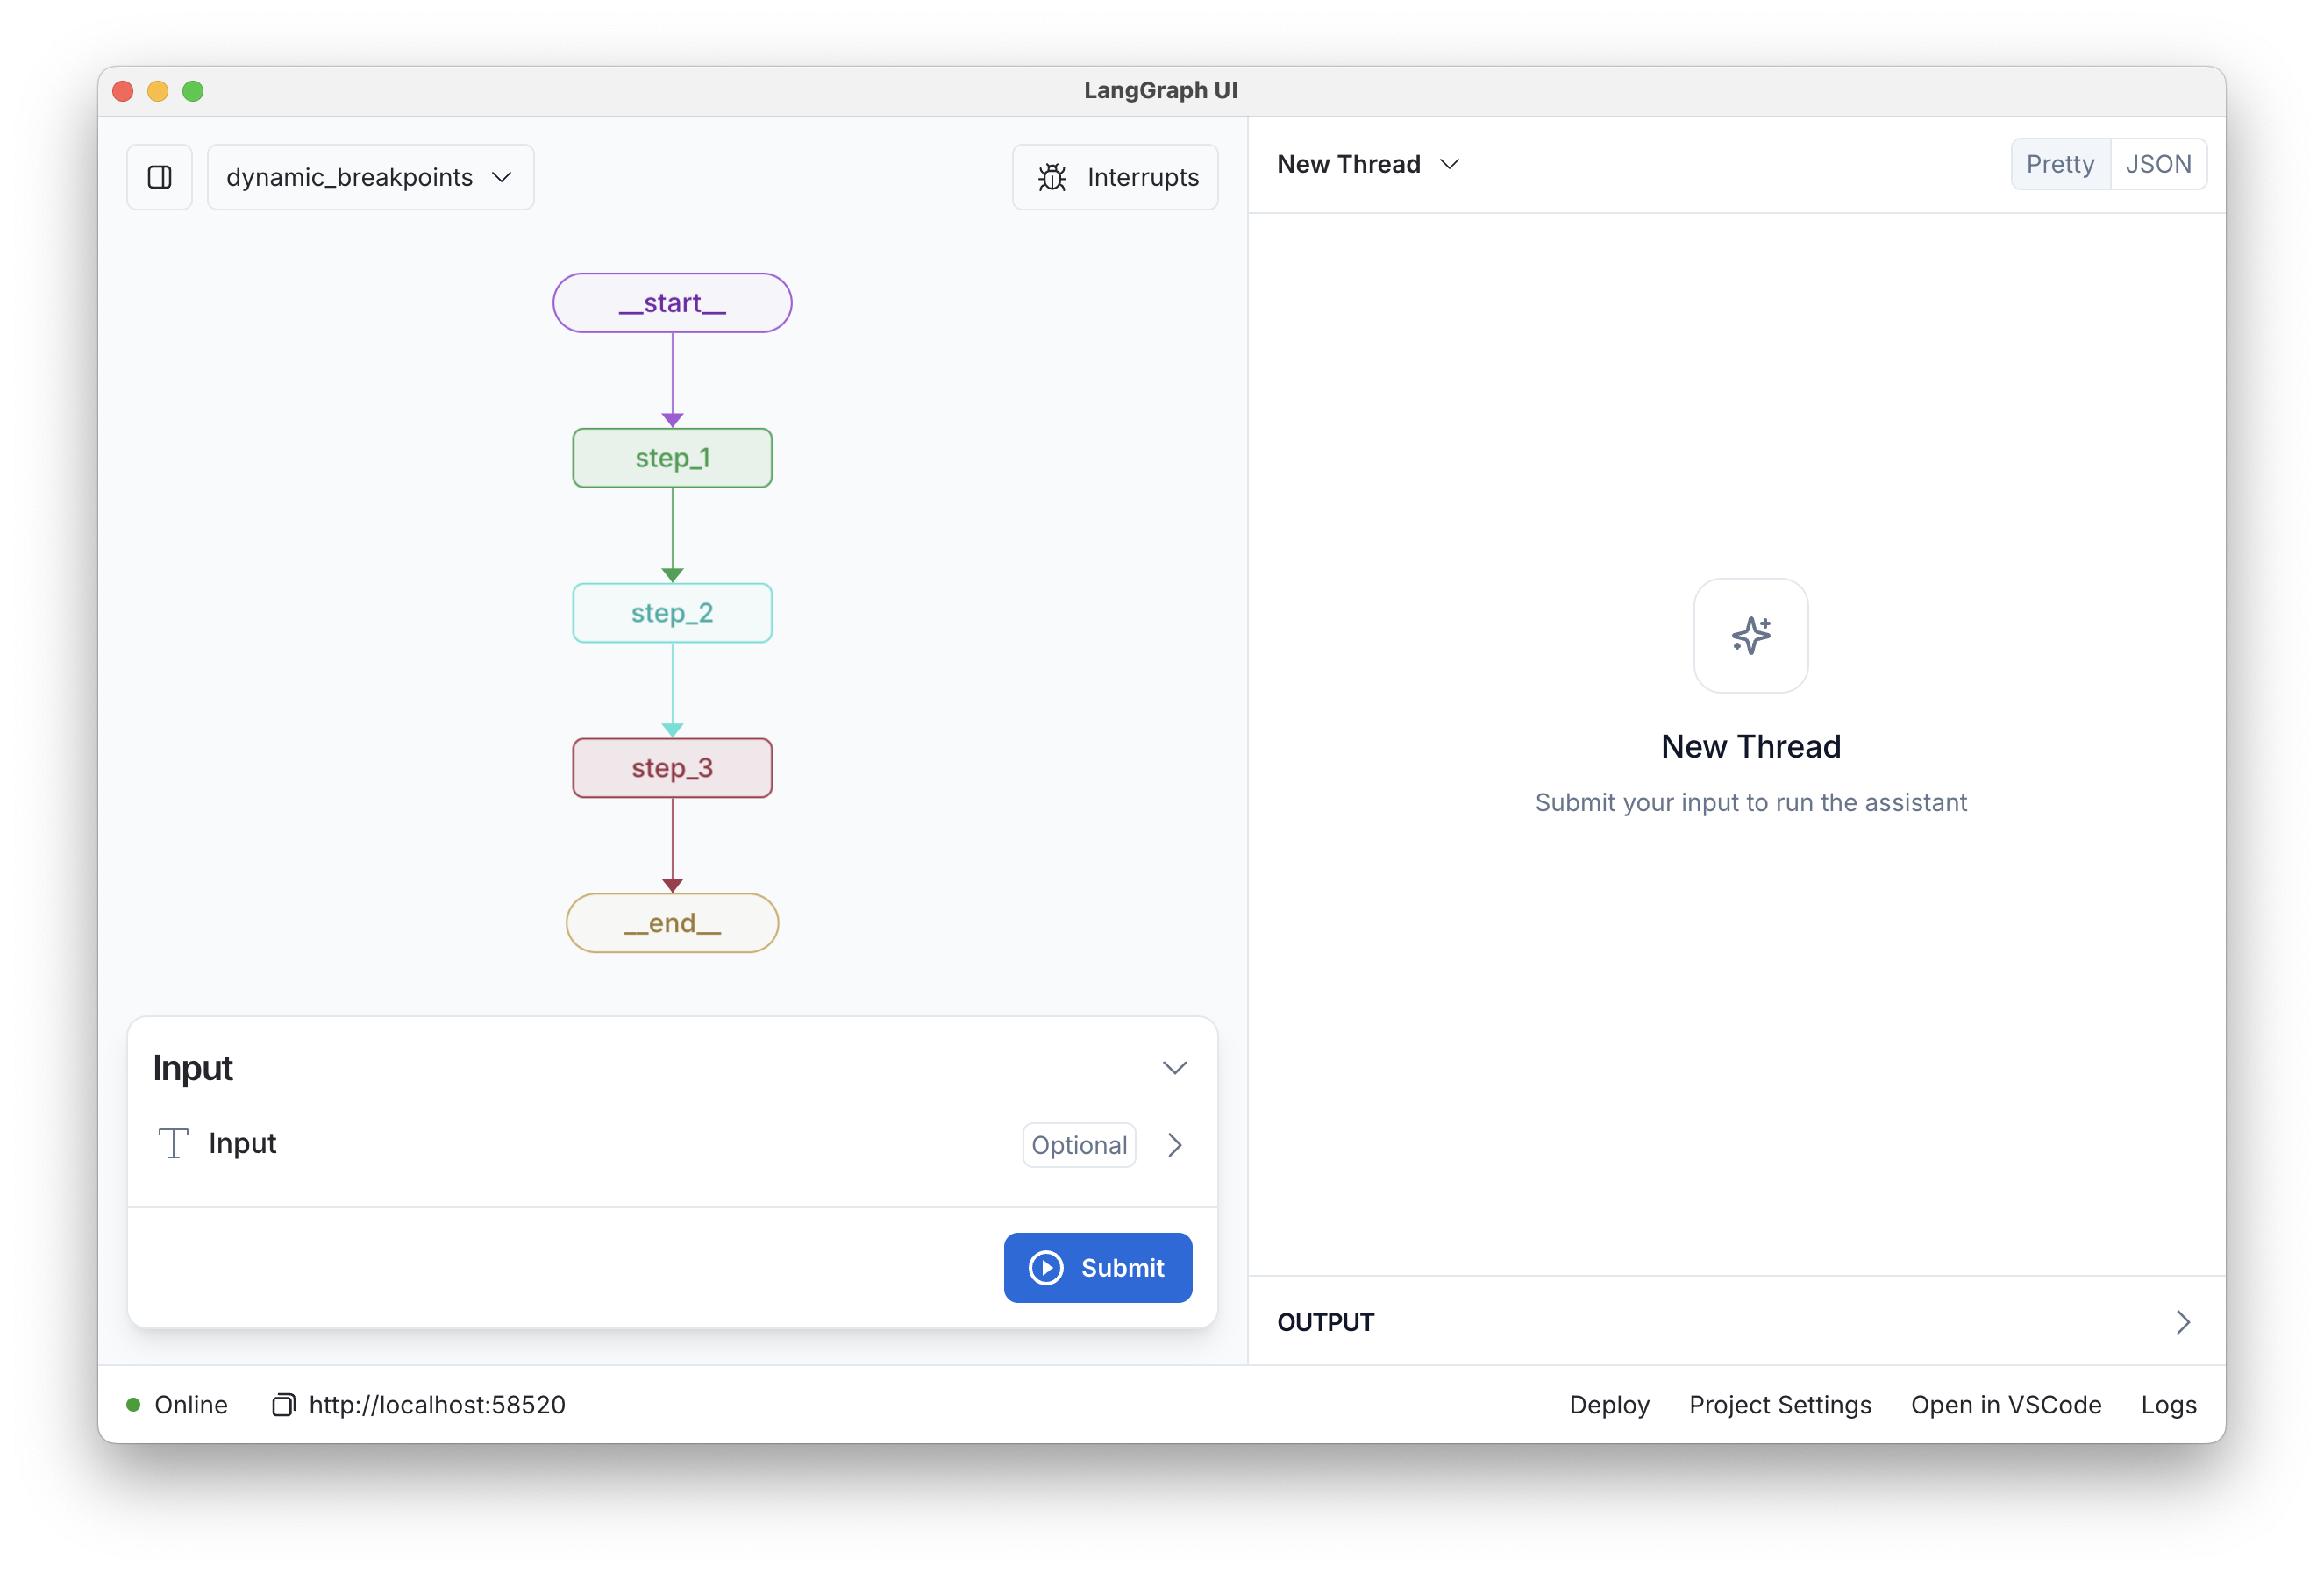

We connect to it via the SDK.

In [18]:
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "http://localhost:58520"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()
assistants

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'created_at': '2024-08-27T21:01:02.392904+00:00',
  'updated_at': '2024-08-27T21:01:02.392904+00:00',
  'config': {},
  'metadata': {'created_by': 'system'}},
 {'assistant_id': '453d1cbf-0bdd-5d35-a224-394f372c0502',
  'graph_id': 'assistant',
  'created_at': '2024-08-26T02:31:20.171308+00:00',
  'updated_at': '2024-08-26T02:31:20.171308+00:00',
  'config': {},
  'metadata': {'created_by': 'system'}},
 {'assistant_id': '8a4ac7a4-50eb-5206-98cc-4a72345cb1f7',
  'graph_id': 'chatbot',
  'created_at': '2024-08-23T19:11:27.632720+00:00',
  'updated_at': '2024-08-23T19:11:27.632720+00:00',
  'config': {},
  'metadata': {'created_by': 'system'}},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'created_at': '2024-08-21T20:12:16.736999+00:00',
  'updated_at': '2024-08-21T20:12:16.736999+00:00',
  'config': {},
  'metadata': {'created_by': 'system'}},
 {'assistant

In [19]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef64c31-a49a-62e6-a393-651f9e1ba131'}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}





In [20]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'hello world'},
 'next': ['step_2'],
 'tasks': [{'id': '42b658dc-f3ca-5edd-a63f-b2bfeb0a086d',
   'name': 'step_2',
   'error': None,
   'interrupts': [{'value': 'Received input that is longer than 5 characters: hello world',
     'when': 'during'}]}],
 'metadata': {'step': 1,
  'run_id': '1ef64c31-a49a-62e6-a393-651f9e1ba131',
  'source': 'loop',
  'writes': {'step_1': {'input': 'hello world'}},
  'user_id': '',
  'graph_id': 'dynamic_breakpoints',
  'thread_id': '07460413-e7fc-47ba-99b8-4bf9b7420cef',
  'created_by': 'system',
  'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c'},
 'created_at': '2024-08-27T22:24:19.442376+00:00',
 'checkpoint_id': '1ef64c31-a4ce-6c2d-8001-6eb6a9d11590',
 'parent_checkpoint_id': '1ef64c31-a4c5-6266-8000-e458c0703788'}

In [21]:
current_state['next']

['step_2']

In [22]:
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

{'configurable': {'thread_id': '07460413-e7fc-47ba-99b8-4bf9b7420cef',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64c33-9d21-65d9-8002-7e576329c42d'},
 'checkpoint_id': '1ef64c33-9d21-65d9-8002-7e576329c42d'}

In [23]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef64c33-fb34-6eaf-8b59-1d85c5b8acc9'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [24]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'hi!'},
 'next': [],
 'tasks': [],
 'metadata': {'step': 4,
  'run_id': '1ef64c33-fb34-6eaf-8b59-1d85c5b8acc9',
  'source': 'loop',
  'writes': {'step_3': {'input': 'hi!'}},
  'user_id': '',
  'graph_id': 'dynamic_breakpoints',
  'thread_id': '07460413-e7fc-47ba-99b8-4bf9b7420cef',
  'created_by': 'system',
  'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c'},
 'created_at': '2024-08-27T22:25:22.339426+00:00',
 'checkpoint_id': '1ef64c33-fca4-601a-8004-c84f16a81121',
 'parent_checkpoint_id': '1ef64c33-fc99-6e0c-8003-f370c9d53b9c'}